# Tests
Not strictly unit tests, each cell tests a different limit of the simulation

In [1]:
%load_ext autoreload
%autoreload 2

import NLTE.NLTE_model
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import astropy.constants as const

# Test of Radiation solver

In [2]:

nlte_solver = NLTE.NLTE_model.NLTESolver(NLTE.NLTE_model.Environment(T_phot=10000.0))
A, stimulated_emission_rate, absorbtion_rate = nlte_solver.processes[1].get_einstein_rates()
i23S = nlte_solver.states.all_names.index("23S")
i23P = nlte_solver.states.all_names.index("23P")

print("A rates ordered correctly:", A[i23S, i23P] > 0 and A[i23P, i23S] == 0)
print("Absorbtion rates ordered correctly:", absorbtion_rate[i23S, i23P] == 0 and absorbtion_rate[i23P, i23S] > 0)
print("Stimulated rates ordered correctly:", stimulated_emission_rate[i23S, i23P] > 0 and stimulated_emission_rate[i23P, i23S] == 0)
print("g factor correct:", np.isclose(absorbtion_rate[i23P, i23S]/stimulated_emission_rate[i23S, i23P],3))

pop_frac = lambda x: x[0]/sum(x)
nlte_solver = NLTE.NLTE_model.NLTESolver(NLTE.NLTE_model.Environment(T_phot=1000.0))
print("Low temperature limit correct: ", 0.99 < pop_frac(nlte_solver.solve(1e6)[1][[i23S, i23P],-1])) # All in lower state
nlte_solver = NLTE.NLTE_model.NLTESolver(NLTE.NLTE_model.Environment(T_phot=10000.0)) # Approaching T->inf
print("High temperature limit correct: ", 0.8 > pop_frac(nlte_solver.solve(1e6)[1][[i23S, i23P],-1]))

A rates ordered correctly: True
Absorbtion rates ordered correctly: True
Stimulated rates ordered correctly: True
g factor correct: True
Low temperature limit correct:  True
High temperature limit correct:  True


In [3]:
states = NLTE.NLTE_model.States()
nlte_solver = NLTE.NLTE_model.NLTESolver(NLTE.NLTE_model.Environment(T_phot=10000.0), states=states)
A, stimulated_emission_rate, absorbtion_rate = nlte_solver.processes[1].get_einstein_rates()
i23P = nlte_solver.states.all_names.index("23P")
i33S = nlte_solver.states.all_names.index("33S")

print("A rates ordered correctly:", A[i23P, i33S] > 0 and A[i33S, i23P] == 0)
print("Absorbtion rates ordered correctly:", absorbtion_rate[i23P, i33S] == 0 and absorbtion_rate[i33S, i23P] > 0)
print("Stimulated rates ordered correctly:", stimulated_emission_rate[i23P, i33S] > 0 and stimulated_emission_rate[i33S, i23P] == 0)
print("g factor correct:", np.allclose(absorbtion_rate[i33S, i23P]/stimulated_emission_rate[i23P, i33S], 1/3))

pop_frac = lambda x: x[0]/sum(x)
nlte_solver = NLTE.NLTE_model.NLTESolver(NLTE.NLTE_model.Environment(T_phot=1000.0), states=states)
print("Low temperature limit correct: ", 0.99 < pop_frac(nlte_solver.solve(1e6)[1][[i23S, i23P],-1])) # All in lower state
nlte_solver = NLTE.NLTE_model.NLTESolver(NLTE.NLTE_model.Environment(T_phot=10000.0), states=states) # Approaching T->inf
print("High temperature limit correct: ", 0.8 > pop_frac(nlte_solver.solve(1e6)[1][[i23S, i23P],-1]))

A rates ordered correctly: True
Absorbtion rates ordered correctly: True
Stimulated rates ordered correctly: True
g factor correct: True
Low temperature limit correct:  True
High temperature limit correct:  True


# Diffuse LTE test
Each radiative transition in diffuse LTE will have population fraction 1/2 of normal LTE

Diffuse LTE between ortho population correct: True


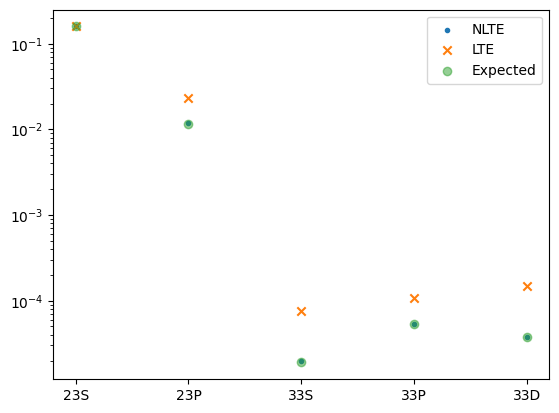

In [15]:
states = NLTE.NLTE_model.States()
nlte_solver = NLTE.NLTE_model.NLTESolver(NLTE.NLTE_model.Environment(T_phot=4400.0), states=states)
rad_process = nlte_solver.processes[1]
nlte_solver.processes = nlte_solver.processes[:2] + nlte_solver.processes[3:]
idx_of = lambda x: nlte_solver.states.all_names.index(x)
min_rate = 0.01
max_rate = 1e2
max_width = 3
for a,b in [("33S", "33P"), ("33P", "33D"), ("21P", "33D"), ("31D", "23P")]:
    idx_a = idx_of(a)
    idx_b = idx_of(b)
    rad_process.A[idx_a, idx_b] = 0
    rad_process.A[idx_b, idx_a] = 0
    rad_process.arbsorbtion_rate[idx_a, idx_b] = 0
    rad_process.arbsorbtion_rate[idx_b, idx_a] = 0
    rad_process.stimulated_emission_rate[idx_a, idx_b] = 0
    rad_process.stimulated_emission_rate[idx_b, idx_a] = 0

y = nlte_solver.solve(1e6)[1][:,-1]
ortho_filter = np.array([name[-2] == "3" for name in states.all_names])
plt.scatter(np.array(states.all_names)[ortho_filter], y[ortho_filter], marker=".", label = f"NLTE");

environment = nlte_solver.environment
bolzman = states.multiplicities * np.exp(-states.energies / (const.k_B * environment.T_phot * u.K))
lte_pop = bolzman[ortho_filter[:-2]] /bolzman[1]  * y[1]
expected_pop = lte_pop * [1, 1/2, 1/4, 1/2, 1/4]
plt.scatter(np.array(states.all_names)[ortho_filter], lte_pop, marker="x", label = f"LTE");
plt.scatter(np.array(states.all_names)[ortho_filter], expected_pop, marker="o", alpha=0.5, label = f"Expected");
print("Diffuse LTE between ortho population correct:", np.allclose(y[ortho_filter], expected_pop, rtol=0.05))
plt.legend()
plt.yscale("log")

# Test of collisional solver

In [6]:
states = NLTE.NLTE_model.States.read_states(filter = lambda table: table["n"] <= 4)
nlte_solver = NLTE.NLTE_model.NLTESolver(NLTE.NLTE_model.Environment(), states=states)
nlte_solver.environment.n_e=1e33
#nlte_solver.processes = nlte_solver.processes[:1]
y = nlte_solver.solve(np.geomspace(1, 1e6))[1][:-2,-1]
#print("High density limit correct: ", 0.5 > pop_frac(nlte_solver.solve(1e6)[1][[i23S, i23P],-1]))
p_i = nlte_solver.states.multiplicities * np.exp(-nlte_solver.states.energies / (const.k_B * nlte_solver.environment.T_electrons*u.K))
pop = p_i / sum(p_i) * sum(y)
pop_frac = lambda x: x/sum(x)
print("High density limit correct: ", np.allclose(pop_frac(y), pop_frac(pop), rtol=1e-2, atol=0))

High density limit correct:  True
